In [1]:
# Standard Python packages
import toml
import math
from pathlib import Path
import json
import h5py

import random

# Workflow management.
from salvus.flow import api

# Specific objects to aid in setting up simulations.
import salvus.flow.simple_config as sc
import salvus.toolbox.toolbox as st
from salvus.mesh.simple_mesh import rho_from_gardeners, vs_from_poisson

import sys
sys.path.append('/home/nolsen/Salvus/Salvus_PDM/CrackSalvus/Helpers/')

from helpers import *
from my_crack import *

import cv2


In [2]:
# Opening JSON file 
f = open('moseley_config_file_3.json',) 
inputs = json.load(f) 
f.close()

In [3]:
nelem_x= inputs['mesh']['nelem_x']
nelem_y= inputs['mesh']['nelem_y']
min_x = inputs['mesh']['x_min']
max_x = inputs['mesh']['x_max']
min_y = inputs['mesh']['y_min']
max_y = inputs['mesh']['y_max']

type = 'earth'

experiment_name = 'Moseley_EARTH_3'

output_folder = inputs['simulation']['output_path'] + "/" + experiment_name

In [4]:
# Create unstructured_mesh 
mesh = get_mesh(nelem_x=nelem_x, nelem_y=nelem_y, max_x=max_x, max_y=max_y)

In [5]:
np.random.seed(1234567) # Fix seed for earth models
random.seed(1234567)

# # # Create the mesh object
mesh_obj = Mesh(mesh,inputs['materials'][0])

# # # Assign the correct type of material and geometry to the mesh

if type == 'crack' : # Fracture 
    final_mesh, dict_materials = mesh_obj.add_crack(crack_obj,inputs['materials'])

elif type == 'earth' : # Earth realistic model
    number_of_separation = np.random.randint(1,5)

    # Create separation for layers
    layers_y = [min_y]
    layers_y += [i for i in np.sort(random.sample(range(min_y+50,max_y-50,50),number_of_separation))]
    layers_y += [max_y]

    vp = np.random.choice(np.array(range(2000,2800,100)),size=number_of_separation+1,replace=False)
    rho = rho_from_gardeners(vp)

    x = np.linspace(0, max_x, nelem_x)
    y = np.linspace(max_y, 0, nelem_y)
    yy, xx = np.meshgrid(y, x, indexing="ij")

    regions = np.zeros((nelem_y,nelem_x))

    for i in range(len(layers_y)-1):

        index = np.argsort(vp)[::-1][i]

        regions[(yy >= layers_y[index]) & (yy <= layers_y[index+1])] = i

    mesh_obj.mesh.elemental_fields["region"] = regions.ravel()

    index_vp = np.argsort(vp)[::-1]

    mesh_obj.add_layers(index_vp,vp,rho)

    final_mesh = mesh_obj.attach_materials()
    dict_materials = {'VP':mesh_obj.vpa,'RHO':mesh_obj.rhoa}


elif type == 'homogeneous' : # Homogeneous
    final_mesh = mesh_obj.attach_materials()
    dict_materials = {'VP':mesh_obj.vpa,'RHO':mesh_obj.rhoa}

else :
    raise TypeError("Not the correct model type was assigned, possible types are 'crack', 'earth' and 'homogeneous'")


# # # Sources
srcs = [
    sc.source.cartesian.ScalarPoint2D(
            x=src['location']['x'],
            y=src['location']['y'],
            f=src['location']['fx'], 
            source_time_function=sc.stf.Ricker(center_frequency=src['frequency']))
         for _i, src in enumerate(inputs['sources'])   
]

# # # Receivers
recs = [
    sc.receiver.cartesian.Point2D(
        x=rec['location']['x'], 
        y=rec['location']['y'], 
        station_code=f"{_i:03d}", 
        fields=[rec['field']])
    for _i, rec in enumerate(inputs['receivers'])
]

In [6]:
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
print('VP',vp)

print('Y Layers',layers_y)

VP [2600 2300 2100 2000 2200]
Y Layers [0, 150, 400, 700, 950, 1500]


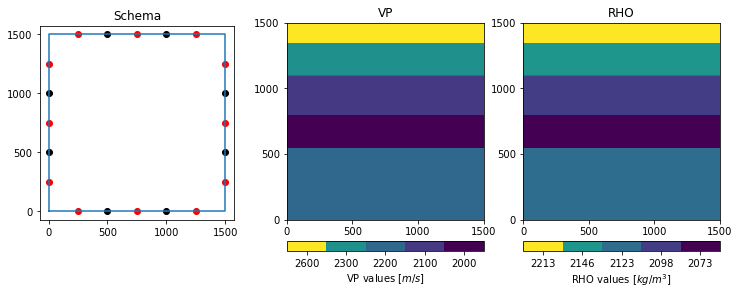

In [8]:
# Plot geometry of the problem - Sanity check 
fig, ax = plt.subplots(1,3,figsize=(12,6))

ax = ax.ravel()

ax[0].plot([min_x,max_x,max_x,min_x,min_x],[min_y,min_y,max_y,max_y,min_y])

# Plot receivers - in black below
for i in range(len(recs)):
    ax[0].scatter(
    recs[i].get_dictionary()['location'][0],recs[i].get_dictionary()['location'][1], c='k'
)
# Plot sources - in red below
for i in range(len(srcs)):
    ax[0].scatter(
    srcs[i].get_dictionary()['location'][0],srcs[i].get_dictionary()['location'][1], c ='r'
)

ax[0].set_aspect('equal')
ax[0].set_title('Schema')
ax[0].set_position([0,0.31,0.45,0.45])
ax[0].set_xticks(range(0, max_x+500, 500))
ax[0].set_yticks(range(0, max_y+500, 500))

for (_i, (name, data)), col, label in zip(enumerate(dict_materials.items()),[vp,rho],['VP values $[m/s]$','RHO values $[kg/m^3]$']):

    _i = _i + 1

    norm = colors.Normalize(vmin=col.min(), vmax=col.max())
    cmap = mpl.colors.ListedColormap(mpl.cm.viridis(norm(np.sort(col)[::-1]),bytes=True)/255)

    im = ax[_i].imshow(np.flipud(regions), cmap=cmap,extent=[min_x,max_x,min_y,max_y])
    ax[_i].set_aspect('equal')
    ax[_i].set_xticks(range(0, max_x+500, 500))
    ax[_i].set_yticks(range(0, max_y+500, 500))

    divider = make_axes_locatable(ax[_i])
    cax = divider.append_axes("bottom", size="5%", pad=0.3)

    cbar = plt.colorbar(im, cax=cax,label=label,orientation="horizontal")

    tick_locs = (np.arange(len(col)) + 0.5)*(len(col)-1)/len(col)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.sort(col)[::-1].astype(int))

    ax[_i].set_title(name)

plt.savefig('Moseley_Earth_3.pdf',bbox_inches='tight')

In [9]:
# Save VP values for NN : 
image_name = 'Velocity_Field_2.npy'
image = np.flipud(dict_materials['VP'].reshape(300,300).astype(int))

with open(image_name, 'wb') as f:
    np.save(f, image)

In [10]:
salvus_sim = SalvusSimulation(mesh=final_mesh, srcs=srcs, recs=recs, output_folder=output_folder)


EVENT0000


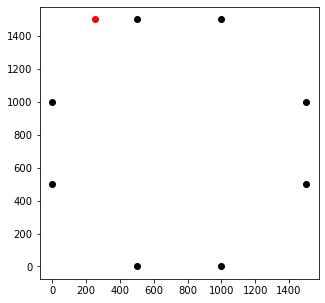

Job `job_2105282049417970_b10dfe3dc9` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0000`.
* Total run time: 86.66 seconds.
* Pure simulation time: 80.51 seconds.

EVENT0001


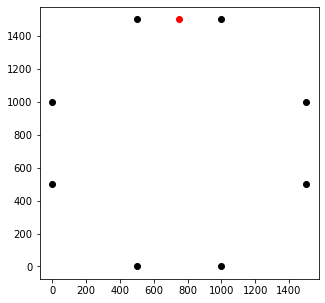

Job `job_2105282051997173_3a345b602f` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0001`.
* Total run time: 94.49 seconds.
* Pure simulation time: 84.47 seconds.

EVENT0002


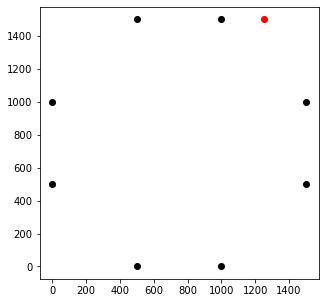

Job `job_2105282052433088_0167c6f10a` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0002`.
* Total run time: 95.40 seconds.
* Pure simulation time: 80.86 seconds.

EVENT0003


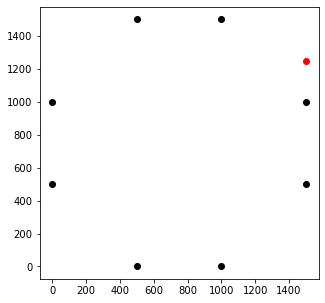

Job `job_2105282054747905_e342dd99d8` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0003`.
* Total run time: 113.62 seconds.
* Pure simulation time: 83.69 seconds.

EVENT0004


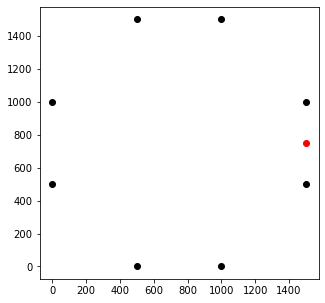

Job `job_2105282056399428_3697d435aa` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0004`.
* Total run time: 119.92 seconds.
* Pure simulation time: 97.21 seconds.

EVENT0005


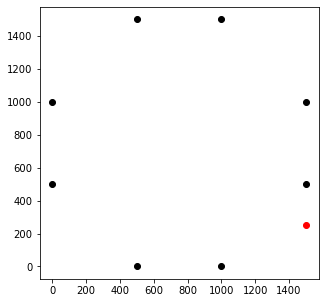

Job `job_2105282058264027_026c85f7ff` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0005`.
* Total run time: 102.40 seconds.
* Pure simulation time: 88.77 seconds.

EVENT0006


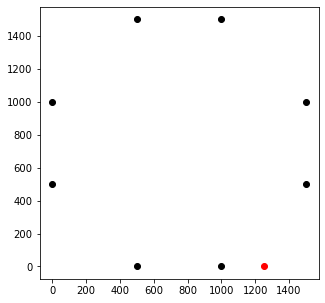

Job `job_2105282100510772_3144f91397` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0006`.
* Total run time: 103.43 seconds.
* Pure simulation time: 84.14 seconds.

EVENT0007


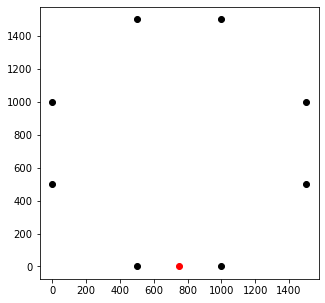

Job `job_2105282101740039_93bcc11d43` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0007`.
* Total run time: 101.33 seconds.
* Pure simulation time: 81.95 seconds.

EVENT0008


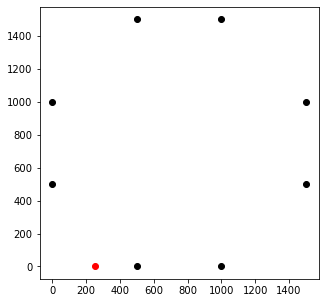

Job `job_2105282103852972_c16d71f153` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0008`.
* Total run time: 107.27 seconds.
* Pure simulation time: 76.20 seconds.

EVENT0009


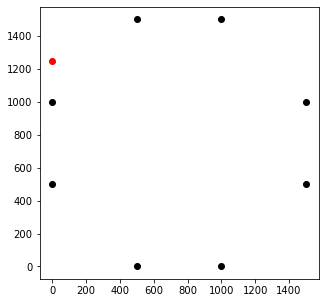

Job `job_2105282105831167_2062fb62ed` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0009`.
* Total run time: 84.95 seconds.
* Pure simulation time: 71.37 seconds.

EVENT0010


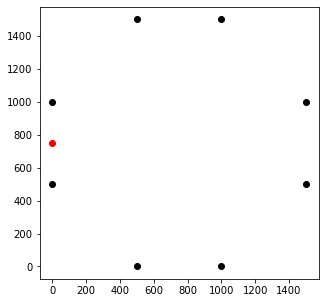

Job `job_2105282106449563_5d6c501f0e` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0010`.
* Total run time: 88.65 seconds.
* Pure simulation time: 73.78 seconds.

EVENT0011


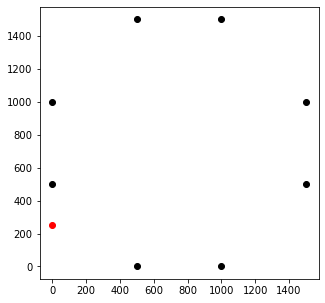

Job `job_2105282108821210_8d908f89bf` running on `local` with 4 rank(s).
Site information:
  * Salvus version: 0.11.31
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/2500 [00:00<?, ?it/s]

* Downloaded 2.8 GB of results to `ForwardOutput/Moseley/Moseley_EARTH_3/EVENT0011`.
* Total run time: 82.04 seconds.
* Pure simulation time: 69.25 seconds.


In [11]:
salvus_sim.run(start_time=inputs['simulation']['start_time'],
        end_time=inputs['simulation']['end_time'],
        time_step=inputs['simulation']['end_time']/2000,
        wavefield_sampling=10)